### Transfer Learning VGG16 unfreeze des 4 dernières couches
> Reprise du modèle entrainé sur la classification

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import gradcam

In [2]:
src_img = '../images_mendeley/dataset_redim/'

#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [3]:
data = pd.read_csv('../mendeley_cells_redim.csv',index_col=0)
data_train, data_eval = train_test_split(data,test_size=0.2,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.2,random_state=123)

#### Utilisation d'un ImageDataGenerator sans transformation pour simplement redimensionné les images en 224*224 et chargé depuis un path

In [4]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator.flow_from_dataframe(data_train, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

test_generator = data_generator.flow_from_dataframe(data_test, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

Found 10938 validated image filenames belonging to 8 classes.
Found 2735 validated image filenames belonging to 8 classes.


In [5]:
# Création Callback pour stopper si pas stagnation
callback = EarlyStopping(monitor='val_loss', patience=2)

###### Récupération du modèle entrainé sur la classification

In [6]:
from keras.models import load_model
# load model
model = load_model('vgg16')

In [7]:
for layer in model.layers: 
    print(layer.name, layer.trainable)

vgg16 True
global_average_pooling2d_1 True
dense_4 True
dense_5 True
dense_6 True
dense_7 True


In [8]:
#Modele VGG16 : 1er layer
base_model = model.layers[0]

#### Freeze les couches de VGG16  sauf les 4 dernièrespour affiner les poids du modèle
> learning rate à 1e-4 pour ne pas trop dérégler les poids pré-entrainés

In [9]:
# Freeze les 4 dernières couches VGG16
for layer in base_model.layers[:-4]: 
    layer.trainable = False

In [10]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs = 10,batch_size = 32, validation_data = test_generator,callbacks=[callback])

Epoch 1/10
342/342 [==============================] - 4228s 12s/step - loss: 0.2956 - accuracy: 0.9152 - val_loss: 0.1028 - val_accuracy: 0.9631
Epoch 2/10
342/342 [==============================] - 4197s 12s/step - loss: 0.0972 - accuracy: 0.9665 - val_loss: 0.0965 - val_accuracy: 0.9664
Epoch 3/10
342/342 [==============================] - 4195s 12s/step - loss: 0.0561 - accuracy: 0.9813 - val_loss: 0.0935 - val_accuracy: 0.9693
Epoch 4/10
342/342 [==============================] - 4217s 12s/step - loss: 0.0426 - accuracy: 0.9849 - val_loss: 0.1347 - val_accuracy: 0.9627
Epoch 5/10
342/342 [==============================] - 4202s 12s/step - loss: 0.0414 - accuracy: 0.9853 - val_loss: 0.1027 - val_accuracy: 0.9678


In [11]:
model.save('vgg16_4')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vgg16_4\assets


#### Prédictions sur données évaluations

In [12]:
eval_generator = data_generator.flow_from_dataframe(data_eval, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)
predict = model.predict(eval_generator)

Found 3419 validated image filenames belonging to 8 classes.


In [13]:
model.evaluate(eval_generator,batch_size=32)

107/107 [==============================] - 887s 8s/step - loss: 0.1038 - accuracy: 0.9710


[0.10384601354598999, 0.9710441827774048]

In [14]:
#Classes prédites
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       1.00      0.97      0.98       222
  eosinophil       1.00      0.99      0.99       627
erythroblast       0.95      0.99      0.97       311
          ig       0.95      0.93      0.94       590
  lymphocyte       0.98      0.94      0.96       236
    monocyte       0.98      0.92      0.95       302
  neutrophil       0.94      0.99      0.96       682
    platelet       1.00      1.00      1.00       449

    accuracy                           0.97      3419
   macro avg       0.97      0.97      0.97      3419
weighted avg       0.97      0.97      0.97      3419



> Légère Amélioration des prédictions : de 96% à 97%
>
> Toujours un rappel faible sur les ig et monocytes

### GRAD CAM

In [15]:
# Regarde nom de la dernière couche convolutive
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 2056      
Total params: 15,898,184
Trainable params: 8,262,920
Non-trainable params: 7,635,264
___________________________________

In [17]:
# Reconstruit le modèle car problème de base_model avec GradCam
x = base_model.output
x = model.get_layer('global_average_pooling2d_1')(x)
x = model.get_layer('dense_4')(x)
x = model.get_layer('dense_5')(x)
x = model.get_layer('dense_6')(x)
x = model.get_layer('dense_7')(x)

In [18]:
model = Model(inputs = base_model.input, outputs = x)

In [19]:
img_size = (224, 224)
last_conv_layer_name = "block5_conv3"
# Remove last layer's softmax
model.layers[-1].activation = None

##### Basophil

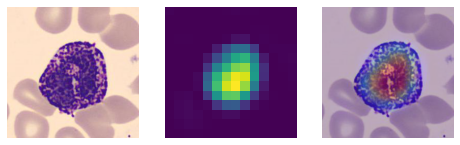

In [20]:
gradcam.display_headmap(preprocess_input, src_img + 'N_BA_200697.jpg', img_size, model, last_conv_layer_name)

##### Eosinophil

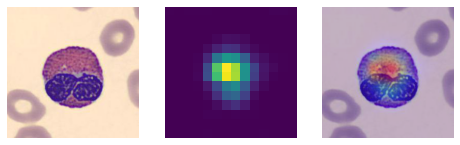

In [21]:
gradcam.display_headmap(preprocess_input, src_img + 'N_EO_40758.jpg', img_size, model, last_conv_layer_name)

##### Erythroblast

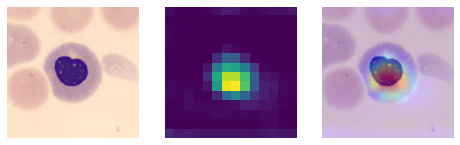

In [22]:
gradcam.display_headmap(preprocess_input, src_img + 'N_ERB_80122.jpg', img_size, model, last_conv_layer_name)

##### IG

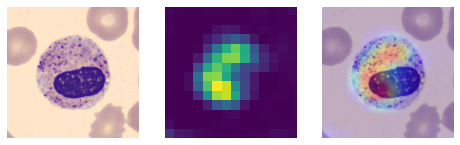

In [23]:
gradcam.display_headmap(preprocess_input, src_img + 'N_MMY_19855.jpg', img_size, model, last_conv_layer_name)

##### Lymphocyte

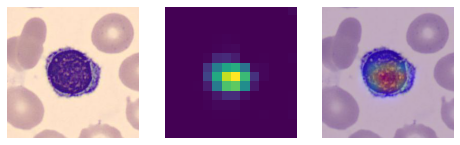

In [24]:
gradcam.display_headmap(preprocess_input, src_img + 'N_LY_99706.jpg', img_size, model, last_conv_layer_name)

##### Monocyte

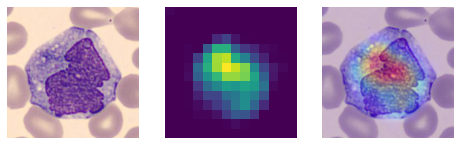

In [25]:
gradcam.display_headmap(preprocess_input, src_img + 'N_MO_60562.jpg', img_size, model, last_conv_layer_name)

##### Neturophil

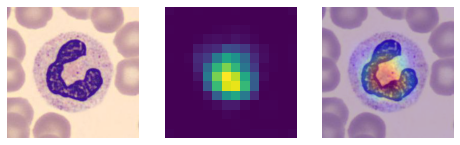

In [26]:
gradcam.display_headmap(preprocess_input, src_img + 'N_BNE_53394.jpg', img_size, model, last_conv_layer_name)

##### Platelet

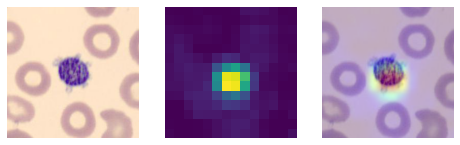

In [27]:
gradcam.display_headmap(preprocess_input, src_img + 'N_PLATELET_4736.jpg', img_size, model, last_conv_layer_name)

> Prise en compte uniquement de certaines zones de la cellule: semble bien identifier les bonnes features
>
> Prise en compte d'une partie du noyau ainsi que d'une partie du cytoplasme, ce qui permet de bien identifier les différentes granularités du cytoplasme selon les types de cellules

#### Matrice de confusion

In [28]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Réalité,,,,,,,,
basophil,216,0,0,6,0,0,0,0
eosinophil,0,619,1,1,1,0,5,0
erythroblast,0,0,308,2,0,0,1,0
ig,0,0,2,551,1,3,33,0
lymphocyte,0,0,9,2,223,2,0,0
monocyte,1,2,2,12,3,279,3,0
neutrophil,0,0,1,6,0,0,675,0
platelet,0,0,0,0,0,0,0,449


> Mauvais rappel ig car cellules prédites en neutrophil, ce qui peut s'expliquer par des caractéristiques communes (IG peut être une cellule neutrophil immature)
>
> Mauvais rappel monocyte , car prédites en IG
>
> La reconnaissance des IG posent vraiment problème => test de classification des 7 autres cellules seules?